In [1]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from fastai.vision import *
from sklearn.utils import shuffle # shuffling
import matplotlib.pyplot as plt # plots
from torch.utils.data.sampler import * # data samplers
import torchvision.transforms as transforms # transforms
from sklearn.metrics import roc_auc_score, accuracy_score
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision
import torch.optim as optim

from utils import *
from dataset import *
from network import *

In [2]:
BATCH_SIZE = 128
VALIDATION_SET_SIZE = 0.1 # percentage of training set used for validation
SAMPLE_SIZE = 80000 # sample size from each category
EPOCHS = 20

# set project directories and files
ROOT_DIRECTORY = "../../../../licenta/"
DATA_DIRECTORY = ROOT_DIRECTORY + "data"
TRAIN_PATH = DATA_DIRECTORY + "/train"
TEST_PATH = DATA_DIRECTORY + "/test"
TRAIN_LABELS = DATA_DIRECTORY + "/train_labels.csv"
SUBMISSION_LABELS = DATA_DIRECTORY + "/sample_submission.csv"
MODEL = ROOT_DIRECTORY + "proiect-licenta-2020/models/cnn.pt"

data_path = Path(DATA_DIRECTORY)
print_files(data_path)

# data analysis
submission_labels = pd.read_csv(SUBMISSION_LABELS)
train_labels = pd.read_csv(TRAIN_LABELS)
train_labels.head()

..\..\..\..\licenta\data\models
..\..\..\..\licenta\data\sample_submission.csv
..\..\..\..\licenta\data\test
..\..\..\..\licenta\data\train
..\..\..\..\licenta\data\train_labels.csv


id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0

In [3]:
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
id       220025 non-null object
label    220025 non-null int64
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


In [4]:
print("Train: {} images".format(len(os.listdir(TRAIN_PATH))))
print("Test: {} images".format(len(os.listdir(TEST_PATH))))

Train: 220025 images
Test: 57458 images


In [5]:
train_labels['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

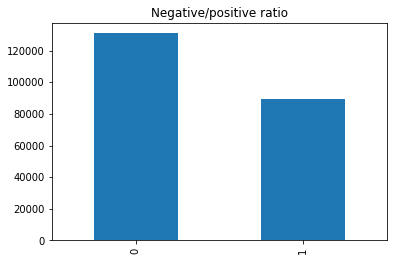

In [6]:
labels_count = train_labels['label'].value_counts()
labels_count.plot(kind='bar', title='Negative/positive ratio')

In [7]:
# get random samples from the data
random_data = shuffle(train_labels)

Text(0, 0.5, 'Positive samples')

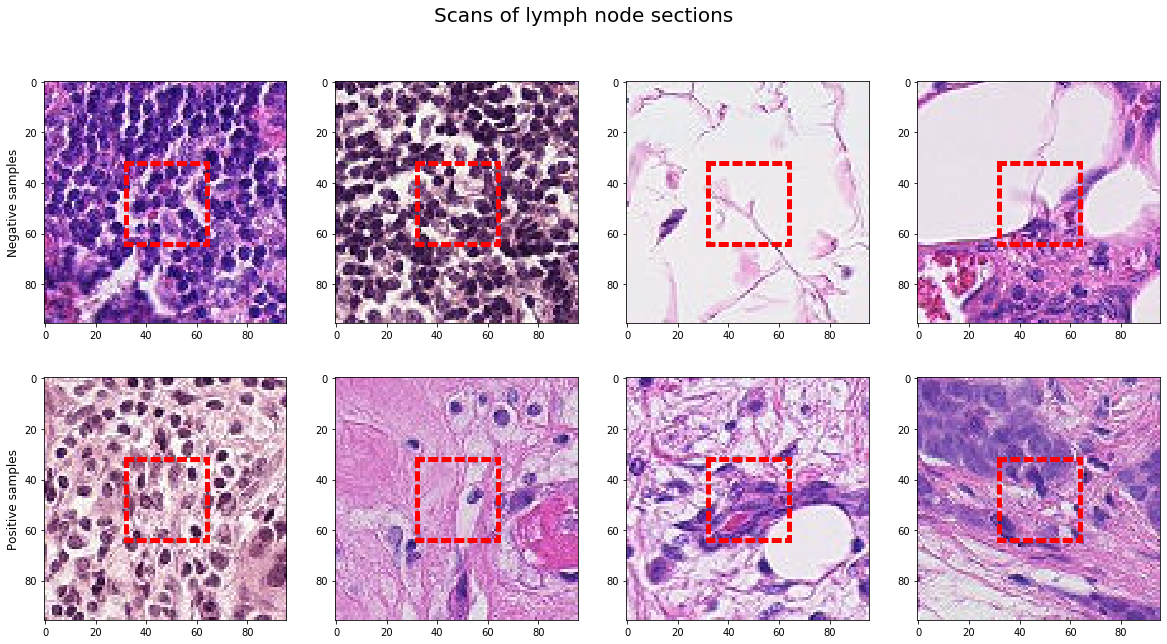

In [8]:
figure, ax = plt.subplots(2,4, figsize=(20,10))
figure.suptitle('Scans of lymph node sections',fontsize=20)

for image_iterator, image_id in enumerate(random_data[random_data['label'] == 0]['id'][:4]):
    path = os.path.join(TRAIN_PATH, image_id)
    ax[0,image_iterator].imshow(read_image(path + '.tif'))
    # show the centered 32x32 patch
    patch = patches.Rectangle((32,32),32,32,linewidth=5,edgecolor='r',facecolor='none', linestyle=':', capstyle='projecting')
    ax[0,image_iterator].add_patch(patch)
ax[0,0].set_ylabel('Negative samples', size='large')

for image_iterator, image_id in enumerate(random_data[random_data['label'] == 1]['id'][:4]):
    path = os.path.join(TRAIN_PATH, image_id)
    ax[1,image_iterator].imshow(read_image(path + '.tif'))
    patch = patches.Rectangle((32,32),32,32,linewidth=5,edgecolor='r',facecolor='none', linestyle=':', capstyle='projecting')
    ax[1,image_iterator].add_patch(patch)
ax[1,0].set_ylabel('Positive samples', size='large')

In [9]:
# creating a balanced data frame with equal positive and negative samples

negative_subset = train_labels[train_labels['label'] == 0].sample(SAMPLE_SIZE, random_state=42)
positive_subset = train_labels[train_labels['label'] == 1].sample(SAMPLE_SIZE, random_state=42)

train_data_frame = shuffle(pd.concat([positive_subset, negative_subset], axis=0).reset_index(drop=True))

In [10]:
train_data_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p=0.4),
    transforms.RandomVerticalFlip(p=0.4),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_data_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [11]:
train_data = CustomDataset(data=train_data_frame, directory=TRAIN_PATH, transform=train_data_transforms)

train_data_number = len(train_data)
indices = list(range(train_data_number))

test_data = CustomDataset(data=submission_labels, directory=TEST_PATH, transform=test_data_transforms)

In [12]:
# splitting the train data
split = int(np.floor(VALIDATION_SET_SIZE * train_data_number))
train_indices, validation_indices = indices[split:], indices[:split]

In [13]:
# create samplers
train_sampler = SubsetRandomSampler(train_indices)
validation_sampler = SubsetRandomSampler(validation_indices)

# create data loaders
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, sampler=train_sampler)
validation_loader = DataLoader(train_data, batch_size=BATCH_SIZE, sampler=validation_sampler)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [14]:
# creating our model
model = Network()

gpu = torch.cuda.is_available()
if gpu: 
    model.cuda()

In [15]:
loss_function = nn.BCELoss()
# set minimum as a very very large number
validation_loss_minimum = np.Inf
optimizer = optim.Adam(model.parameters(), lr=0.00015)

auc_scores = []
auc_epoch = []
train_losses = []
validation_losses = []

In [16]:
for epoch in range(0, EPOCHS):
    
    train_loss = 0.0
    validation_loss = 0.0
    
    # train model
    print('Start training model, epoch: {} '.format(epoch+1))
    model.train()
    
    for data, target in train_loader:
         
        if gpu:
            data, target = data.cuda(), target.cuda()
            
        target = target.float()
        target = target.view(-1, 1)

        optimizer.zero_grad()
        
        # forward passing
        output = model(data)
        
        # batch loss
        loss = loss_function(output, target)
        
        # backward passing 
        loss.backward()
        
        optimizer.step()
        
        # update train loss
        train_loss += loss.item()*data.size(0)
    
    # validate model
    model.eval()
    for data, target in validation_loader:
         
        if gpu:
            data, target = data.cuda(), target.cuda()
        
        target = target.float()
        target = target.view(-1, 1)
        
        output = model(data)

        loss = loss_function(output, target)
        
        # update validation loss
        validation_loss += loss.item()*data.size(0)

        actual = target.data.cpu().numpy()
        predicted = output[:,-1].detach().cpu().numpy()
        auc_scores.append(roc_auc_score(actual, predicted))  
    
    train_loss = train_loss/len(train_loader.sampler)
    validation_loss = validation_loss/len(validation_loader.sampler)
    validation_auc = np.mean(auc_scores)
    auc_epoch.append(validation_auc)
    train_losses.append(train_loss)
    validation_losses.append(validation_loss)
    
    print('Training loss: {:.5f} , Validation loss: {:.5f} , Validation AUC: {:.5f} \n'.format(train_loss, validation_loss, validation_auc))
    
    # stop if validation loss is greater than the last one
    if validation_loss <= validation_loss_minimum:
        print('Validation loss decreased: {:.5f} -> {:.5f}. \n\n'.format(validation_loss_minimum, validation_loss))
        torch.save(model.state_dict(), 'cnn.pt')
        validation_loss_minimum = validation_loss

In [17]:
%matplotlib inline
plt.plot(train_losses, label='Training loss')
plt.plot(validation_losses, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=True)

In [18]:
%matplotlib inline
plt.plot(auc_epoch)
plt.xlabel("Epochs")
plt.ylabel("Area Under the Curve")

In [19]:
# load parameters
if gpu:
    model.load_state_dict(torch.load(MODEL))
else:
    model.load_state_dict(torch.load(MODEL, map_location=torch.device('cpu')))

In [20]:
model.eval()

predictions = []
for batch_index, (data, target) in enumerate(test_loader):
    if gpu:
        data, target = data.cuda(), target.cuda()
    output = model(data)
    preds = output.detach().cpu().numpy()
    for prediction in preds:
        predictions.append(prediction)

In [21]:
submission_labels['label'] = predictions
for index in range(len(submission_labels)):
    submission_labels.label[index] = np.float(submission_labels.label[index])

In [22]:
submission_labels.to_csv('submission.csv', index=False)
submission_labels.head()